In [1]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Import libraries
import os
import xlrd
import math
import zipfile
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
import time
from ctgan.tablegan import TableganSynthesizer
from ctgan import CTGANSynthesizer
from ctgan import TVAESynthesizer
from sklearn.model_selection import train_test_split

In [3]:
num_epochs = 300

In [4]:
home = str(Path.home())

In [5]:
home

'C:\\Users\\stazt'

In [6]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/Reduced to Benchmarks-1.csv')

In [7]:
OVS1618.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,679.04,0,400.0,0,-1.0,1,400.0,0,50.0,0,...,1,1,0,0,0,0,0,1,1,0
1,-1.00,1,130.0,0,100.0,0,30.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
2,-1.00,1,120.0,0,120.0,0,-1.0,1,40.0,0,...,1,0,0,0,0,0,0,2,0,0
3,-1.00,1,80.0,0,-1.0,1,80.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
4,130.00,0,60.0,0,60.0,0,-1.0,1,40.0,0,...,1,1,0,0,0,0,0,2,0,1


In [8]:
OVS1618.shape

(66030, 38)

In [9]:
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b113_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [10]:
with open(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/binary_categorical_columns.txt',"r+")   as f:
    new_cat_list = f.read().splitlines() 

In [11]:
new_cat_list

['Expenditure on Accommodation (c4.tot.new)_cat',
 'Expenditure on F&B (c6.tot.new)_cat',
 'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat',
 'Expenditure on Casual Dining (c6c_2.r)_cat',
 'Expenditure on Transport (c7.tot.new)_cat',
 'Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat',
 'Expenditure on Sightseeing (c10c_1.r)_cat',
 'Expenditure on Attractions (c10c_2.r)_cat',
 'Expenditure on Shopping (t7.m.any)_cat',
 'Expenditure on Healthcare & Wellness Products (t7.m.well)_cat',
 'Expenditure on Confectionery & Food Items (t7.m.food)_cat',
 'Expenditure on Fashion (t7.m.fash)_cat',
 'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat',
 'Package Expenditure Per Person (c1b.r)_cat']

In [12]:
cat_cols = new_cat_list + list_cat

In [13]:
len(cat_cols)

24

# CTGAN

In [14]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [15]:
OVS1618_train_val.shape

(56125, 38)

In [16]:
OVS1618_test.shape

(9905, 38)

In [19]:
## set seed
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 13
num_components 14
num_components 15
num_components 15
num_components 14
num_components 12
num_components 10
num_components 13
num_components 13
num_components 11
num_components 12
num_components 13
num_components 10
num_components 7
transformed data shape:  (46247, 235)
data dimension: 235
Dropout rate:  0.5
[1.09241724e+00 3.96611436e-04 1.54002629e+00 4.15854229e-04
 1.64499246e+00 3.91872060e-04 1.92746316e+00 4.39575838e-04
 1.90728128e+00 3.89874255e-04 1.73190972e+00 3.99379274e-04
 1.52439631e+00 3.99714283e-04 1.67015514e+00 4.00799038e-04
 1.43662536e+00 4.12491671e-04 1.55343828e+00 3.98226313e-04
 1.78978030e+00 3.99538237e-04 1.46364578e+00 4.08445877e-04
 1.01483488e+00 3.83175692e-04 8.46504253e-01 3.77811900e-04
 6.05385912e-04 3.67158848e-04 3.66946651e-04 3.59396897e-04
 4.13677378e-04 3.7124262

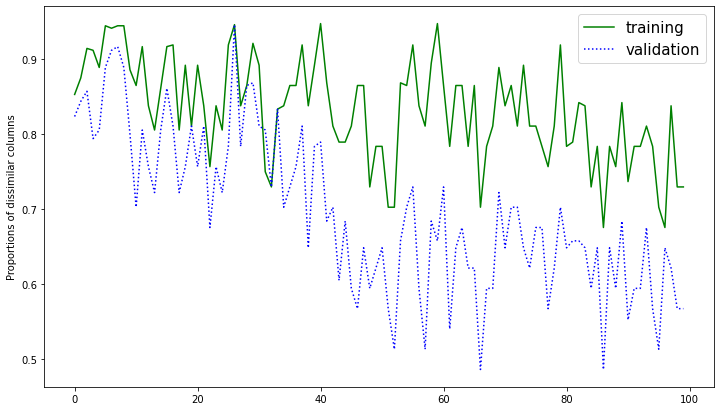

In [20]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [ ]:
## remove seed
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=100, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 14
num_components 12
num_components 10
num_components 13
num_components 14
num_components 10
num_components 13
num_components 12
num_components 12
num_components 7
transformed data shape:  (46247, 234)
data dimension: 234
Dropout rate:  0.5
[1.10784025e+00 4.20121736e-04 1.39287368e+00 3.51779250e-04
 1.67421505e+00 3.46780878e-04 1.80278464e+00 3.72073248e-04
 1.99773053e+00 3.96941609e-04 1.64956582e+00 3.92584715e-04
 1.54903176e+00 4.00884427e-04 1.68512544e+00 4.03779640e-04
 1.49293940e+00 3.93966968e-04 1.59142359e+00 3.90089204e-04
 1.72251841e+00 4.00268054e-04 1.73855548e+00 3.99900613e-04
 1.01245463e+00 3.61082910e-04 8.46774103e-01 3.69667846e-04
 6.19974395e-04 4.17057938e-04 4.09752512e-04 3.79244159e-04
 4.13776659e-04 4.0061138

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=10, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 13
num_components 14
num_components 15
num_components 13
num_components 12
num_components 10
num_components 14
num_components 14
num_components 11
num_components 13
num_components 11
num_components 11
num_components 7
transformed data shape:  (46247, 233)
data dimension: 233
Dropout rate:  0.5
[7.84626786e-01 9.85249779e-05 9.63832620e-01 1.09273378e-04
 9.80830743e-01 1.05234600e-04 9.67731437e-01 9.97383349e-05
 9.68735834e-01 9.73585030e-05 9.55354703e-01 9.87453936e-05
 9.44365843e-01 9.39799895e-05 9.69590347e-01 9.67221156e-05
 9.47016390e-01 1.03611904e-04 9.16948828e-01 9.92713762e-05
 9.38997391e-01 1.05779093e-04 9.67744854e-01 1.01431854e-04
 9.95424449e-01 1.06070221e-04 6.40250714e-01 1.02793175e-04
 2.08518675e-04 9.95726030e-05 1.10462071e-04 1.00067613e-04
 1.06169350e-04 1.0178918

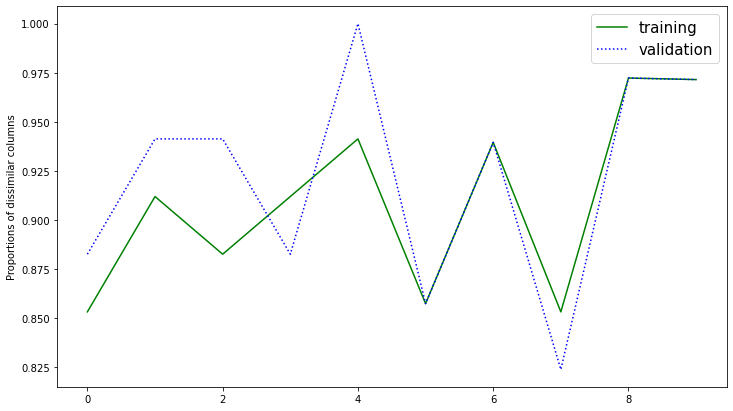

In [18]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [24]:
ctgan.train_KLD

[array([2.75026287e+00, 4.92974014e-05, 3.50831019e+00, 4.42941746e-03,
        3.10029556e+00, 4.84885528e-02, 3.36494314e+00, 2.99592089e-02,
        3.52758460e+00, 1.43727178e-02, 3.86916225e+00, 3.19954688e-03,
                   nan, 3.25322137e-10, 3.26937018e+00, 2.37642767e-03,
        2.87331962e+00, 8.70351598e-05,            nan, 2.52288073e-02,
                   nan, 2.66388799e-04, 4.25538553e+00, 1.50584976e-02,
        9.56622745e-01, 1.12967500e-02,            nan, 7.93805546e-03,
        2.45144897e-03, 1.23212114e-02, 4.47890283e-03, 1.25673660e-02,
        4.83817524e-03, 6.17919552e-03, 9.16031778e-05, 3.54890671e-04,
        5.22239957e-02, 2.11529506e-04]),
 array([2.53399205e+00, 1.54745136e-03, 3.32075924e+00, 6.22832657e-04,
        3.19429828e+00, 1.02513721e-03, 4.42404110e+00, 8.25786654e-03,
        3.37850020e+00, 1.07588632e-05, 3.93558282e+00, 6.02371189e-04,
                   nan, 2.33918288e-03, 3.71142346e+00, 7.92834533e-03,
        3.06455857e+00

In [22]:
from sklearn.utils import resample
import ctgan.metric as M
def determine_threshold(data, n_samples,discrete_columns,n_rep=1000):
    boot_KLD = np.zeros((n_rep,data.shape[1]))
    for i in np.arange(n_rep):
        boot1 = resample(data, replace=True, n_samples=n_samples)
        boot2 = resample(data, replace=True, n_samples=n_samples)
        boot_KLD[i]= M.KLD(boot1,boot2,discrete_columns)
    return boot_KLD

In [23]:
mat = determine_threshold(OVS1618_train_val,10000,cat_cols,1000)

In [25]:
np.nanmean(mat,axis=0)

array([7.76055122e-01, 1.05005562e-04, 9.64938262e-01, 1.02882807e-04,
       9.76180747e-01, 9.93313904e-05, 9.69586816e-01, 9.78096673e-05,
       9.71843669e-01, 1.07255770e-04, 9.81513445e-01, 9.96030457e-05,
       9.49616333e-01, 9.65841013e-05, 9.99850718e-01, 9.95628330e-05,
       9.48991726e-01, 9.87826546e-05, 9.43614936e-01, 1.04432311e-04,
       9.65553771e-01, 9.87330917e-05, 9.70622997e-01, 9.68622579e-05,
       9.94902565e-01, 1.00079872e-04, 6.37054591e-01, 1.03054548e-04,
       1.94616471e-04, 1.03233210e-04, 1.09857951e-04, 9.84526352e-05,
       1.06608335e-04, 1.06628751e-04, 1.08616854e-04, 1.03054548e-04,
       1.00513697e-04, 1.03517604e-04])

In [35]:
np.nanmean(mat,axis=0)+2*np.nanstd(mat,axis=0)

array([1.09739506e+00, 3.96072673e-04, 1.48423068e+00, 3.77817216e-04,
       1.59276927e+00, 3.84591504e-04, 1.85851870e+00, 3.54433380e-04,
       1.92567887e+00, 4.06008830e-04, 1.69507950e+00, 3.86533583e-04,
       1.51350846e+00, 3.64712411e-04, 1.68990255e+00, 3.83967735e-04,
       1.46998955e+00, 3.71907481e-04, 1.59640067e+00, 4.02463392e-04,
       1.74236676e+00, 3.70790633e-04, 1.69061094e+00, 3.71074700e-04,
       1.01569171e+00, 3.72962741e-04, 8.44397568e-01, 3.95455630e-04,
       5.84524037e-04, 3.93797294e-04, 4.18476695e-04, 3.77257222e-04,
       3.98833772e-04, 3.96612109e-04, 4.15210263e-04, 3.95455630e-04,
       3.68663004e-04, 3.91541151e-04])

In [22]:
a = np.array([1,2,3,np.nan])

In [23]:
b = np.array([4,1,3,8])

In [24]:
a-b

array([-3.,  1.,  0., nan])

In [25]:
np.count_nonzero(~np.isnan(a-b))

3

In [27]:
np.count_nonzero(a-b>=0)/np.count_nonzero(~np.isnan(a-b))

0.6666666666666666

In [64]:
sum(1 for x in a-b if x > 0)/len(~np.isnan(a-b))

0.5

In [52]:
a-b>=0)

3

In [46]:
ctgan.train_KLD_con

[array([2.61944821, 3.17435062, 2.76046858, 3.3693444 , 3.83564169,
        4.19225199, 3.93934941, 2.63819048, 3.86407124, 0.95662275]),
 array([2.63053631, 3.07289677, 3.15625255, 3.89112198, 3.10273002,
        3.80156835, 2.8960242 , 0.95662275, 4.29788429]),
 array([2.48598037, 3.11047312, 3.00609658, 4.04059847, 3.22022011,
        3.80267336, 3.39146167, 2.987629  , 3.36100834, 0.95662275]),
 array([2.70500171, 2.44977269, 3.59413652, 4.53794155, 3.15711729,
        3.79570032, 3.57599683, 3.14572036, 2.91401311, 2.80734181,
        0.95662275, 4.28503335]),
 array([2.84006225, 3.17229963, 3.05747037, 4.33446727, 3.40083131,
        3.52246903, 3.85837041, 3.07846739, 2.99407896, 2.80521528,
        0.95662275]),
 array([2.6844858 , 3.29548203, 2.97170771, 3.97064718, 3.12805649,
        3.73456773, 3.27563215, 2.57132396, 4.36309136, 2.91741914,
        2.61747065]),
 array([2.63818713, 3.18978117, 3.63932957, 4.31558297, 3.05518048,
        2.6914876 , 3.14683773, 3.0577015 , 

In [45]:
ctgan.validation_KLD_con

[array([2.04591583, 1.98263186, 1.5259986 , 1.74578618, 2.61541364,
        2.53938924, 2.85176375, 2.07372538, 3.32592249, 0.97740921]),
 array([2.03765981, 1.87499052, 1.90719555, 2.278312  , 1.87570489,
        2.72214609, 2.33409458, 0.97740921, 3.672118  ]),
 array([1.90919073, 1.91107324, 1.79168835, 2.41172091, 2.0005071 ,
        2.16089544, 2.32273376, 2.41508917, 2.85308336, 0.97740921]),
 array([2.13272741, 1.23706686, 2.34682178, 2.90849498, 1.95342531,
        2.15234255, 2.50343612, 2.58544931, 1.83086354, 2.2513986 ,
        0.97740921, 3.67363315]),
 array([2.25792192, 1.96770264, 1.83056181, 2.72065264, 2.18983522,
        1.87966927, 2.76525325, 2.49369981, 1.8643453 , 2.23976503,
        0.97740921]),
 array([2.09182521, 2.10742119, 1.70731307, 2.35752442, 1.91187029,
        2.07938886, 2.19480017, 2.00084832, 3.66533928, 2.40283512,
        2.02743375]),
 array([2.07357112, 1.99526293, 2.38464211, 2.6778643 , 1.83018224,
        1.60978015, 2.56927964, 1.93096466, 

In [41]:
train_prop_con = []
val_prop_con = []
for i in np.arange(len(ctgan.train_KLD_con)):
    train_prop_con.append(len(ctgan.train_KLD_con[i][ctgan.train_KLD_con[i]>=2.6])/len(ctgan.train_KLD_con[i]))
    val_prop_con.append(len(ctgan.validation_KLD_con[i][ctgan.validation_KLD_con[i]>=2.6])/len(ctgan.validation_KLD_con[i]))

In [42]:
train_prop_cat = []
val_prop_cat = []
for i in np.arange(len(ctgan.train_KLD_cat)):
    train_prop_cat.append(len(ctgan.train_KLD_cat[i][ctgan.train_KLD_cat[i]>=0.001])/len(ctgan.train_KLD_cat[i]))
    val_prop_cat.append(len(ctgan.validation_KLD_cat[i][ctgan.validation_KLD_cat[i]>=0.001])/len(ctgan.validation_KLD_cat[i]))

In [59]:
train_sum_cat = []
val_sum_cat = []
for i in np.arange(len(ctgan.train_KLD_cat)):
    train_sum_cat.append(sum(ctgan.train_KLD_cat[i])/len(ctgan.train_KLD_cat[i]))
    val_sum_cat.append(sum(ctgan.validation_KLD_cat[i])/len(ctgan.validation_KLD_cat[i]))

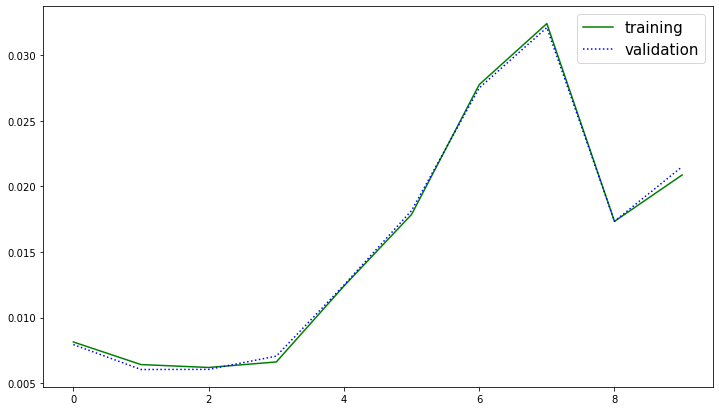

In [60]:
plt.figure(figsize=(12,7))
plt.plot(train_sum_cat,'-g',label='training')
plt.plot(val_sum_cat,':b',label='validation')
plt.legend(fontsize=15);

In [57]:
train_sum_con = []
val_sum_con = []
for i in np.arange(len(ctgan.train_KLD_con)):
    train_sum_con.append(sum(ctgan.train_KLD_con[i])/len(ctgan.train_KLD_con[i]))
    val_sum_con.append(sum(ctgan.validation_KLD_con[i])/len(ctgan.train_KLD_con[i]))

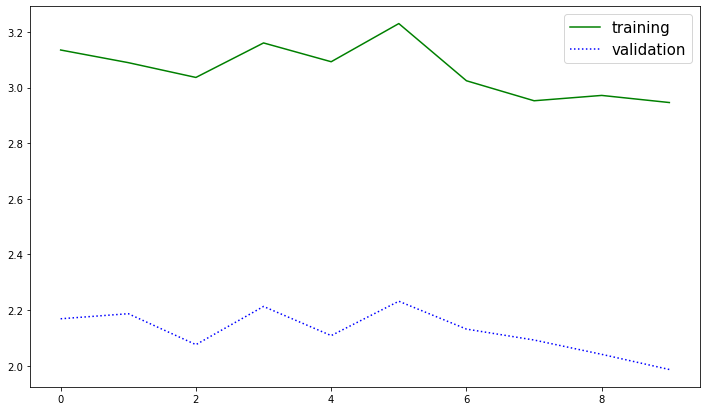

In [58]:
plt.figure(figsize=(12,7))
plt.plot(train_sum_con,'-g',label='training')
plt.plot(val_sum_con,':b',label='validation')
plt.legend(fontsize=15);

In [43]:
train_prop_con

[0.9,
 0.8888888888888888,
 0.8,
 0.8333333333333334,
 0.9090909090909091,
 0.9090909090909091,
 0.8181818181818182,
 0.75,
 0.6923076923076923,
 0.8333333333333334]

In [44]:
val_prop_con

[0.3,
 0.2222222222222222,
 0.1,
 0.16666666666666666,
 0.18181818181818182,
 0.09090909090909091,
 0.18181818181818182,
 0.25,
 0.07692307692307693,
 0.0]

In [37]:
train_prop_cat

[0.75,
 0.7083333333333334,
 0.625,
 0.7083333333333334,
 0.7083333333333334,
 1.0,
 0.7916666666666666,
 0.875,
 0.75,
 0.9166666666666666]

In [38]:
val_prop_cat

[0.7083333333333334,
 0.75,
 0.6666666666666666,
 0.7083333333333334,
 0.7083333333333334,
 1.0,
 0.75,
 0.875,
 0.75,
 0.9583333333333334]

In [39]:
np.sqrt(np.array(train_prop_con)*np.array(train_prop_cat))

array([0.82158384, 0.79349205, 0.75      , 0.80579498, 0.80245834,
       1.        , 0.84834956, 0.875     , 0.83205029, 0.91666667])

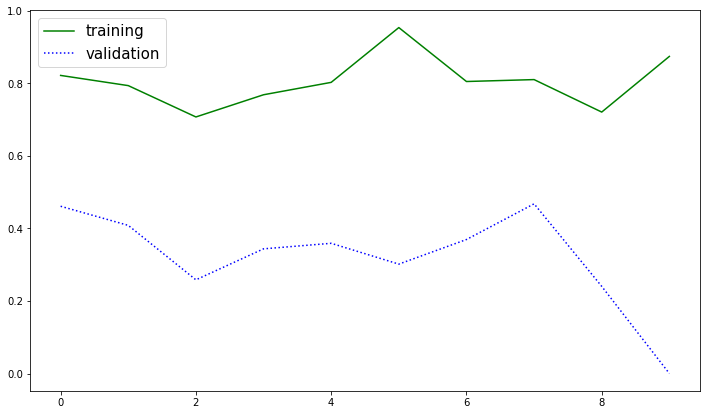

In [47]:
plt.figure(figsize=(12,7))
plt.plot(np.sqrt(np.array(train_prop_con)*np.array(train_prop_cat)),'-g',label='training')
plt.plot(np.sqrt(np.array(val_prop_con)*np.array(val_prop_cat)),':b',label='validation')
plt.legend(fontsize=15);

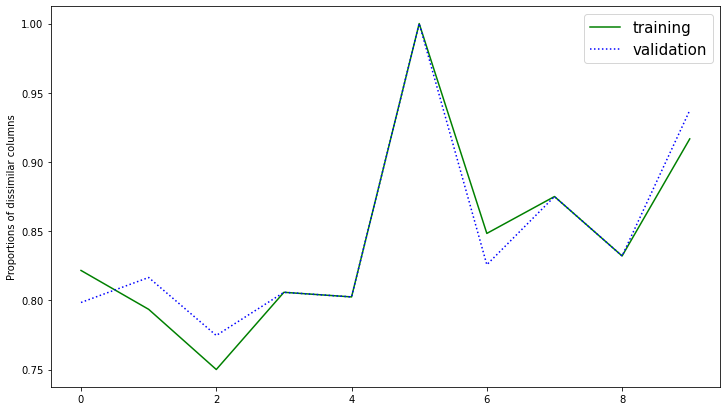

In [20]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [31]:
ctgan.train_KLD

[array([2.57903834e+00, 7.10609395e-04, 2.89515931e+00, 2.13195036e-02,
        3.06286188e+00, 3.12828368e-02, 3.85190886e+00, 2.00267643e-02,
        3.55105299e+00, 1.09427775e-02, 4.67283471e+00, 6.10053609e-05,
        2.19726537e-05, 3.94871565e+00, 3.89667303e-03, 2.95284223e+00,
        4.45817678e-03, 3.95871699e+00, 1.83816748e-02, 3.92236540e-03,
        2.74869390e+00, 2.02379454e-02, 9.56404730e-01, 1.40204326e-02,
        7.17608315e-03, 4.51353709e-03, 8.62425622e-04, 9.59593170e-03,
        3.18230445e-03, 3.88841402e-03, 5.55901731e-03, 2.99486806e-04,
        2.17503349e-03, 7.63880820e-04, 4.97132772e-03]),
 array([2.56864762e+00, 1.63864125e-03, 2.92221122e+00, 1.58447648e-03,
        3.02628018e+00, 2.72760705e-03, 5.27719516e+00, 4.73263831e-02,
        3.75941351e+00, 3.40343408e-03, 1.94527643e-02, 6.72005339e-04,
        1.60054783e-02, 3.39501500e+00, 5.51732774e-03, 4.40257585e-03,
        5.90598968e-03, 3.37901125e+00, 1.08319164e-03, 9.56404730e-01,
      

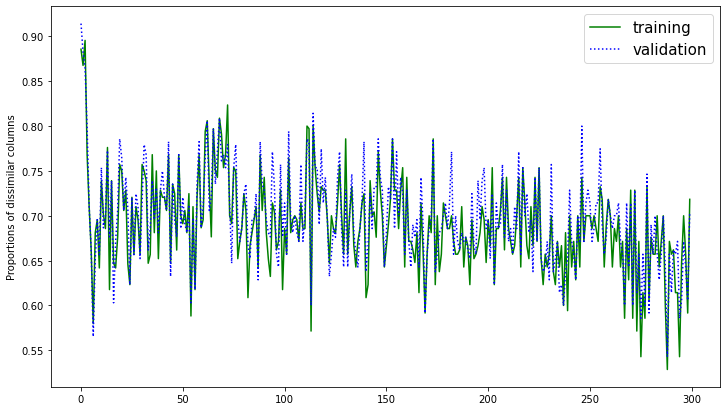

In [14]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

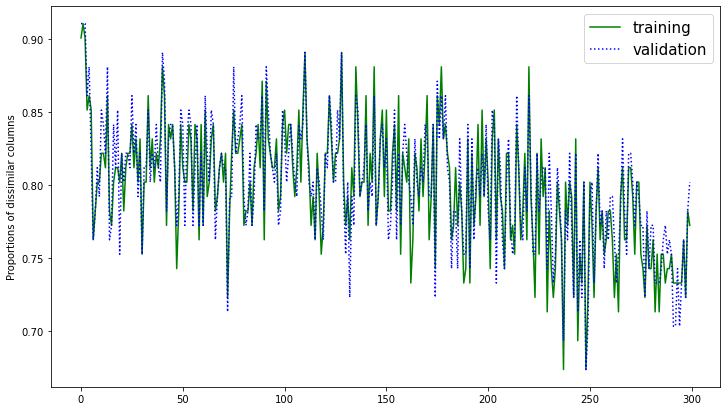

In [17]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_dis_train,'-g',label='training')
plt.plot(ctgan.prop_dis_validation,':b',label='validation')
plt.ylabel('Proportions of dissimilar columns')
plt.legend(fontsize=15);

In [20]:
ctgan.train_KLD

[array([6.29637225e+00, 5.33353039e-02, 1.80876401e+01, 1.13185119e-02,
        1.76690085e+01, 7.77713112e-03, 1.83186401e+01, 3.50043893e-03,
        1.74519456e+01, 2.09514283e-04, 1.83294548e+01, 3.03498462e-03,
        1.84080512e+01, 7.67927648e-03, 1.83799277e+01, 3.77878462e-03,
        8.89320653e+00, 7.07405652e-02, 8.60934337e+00, 6.36118063e-02,
        1.71870967e+01, 4.36066771e-04, 1.83521668e+01, 3.36974062e-03,
        5.80526759e+00, 1.71890461e-02, 1.56953383e+01, 3.95873398e-04,
        1.17143911e+01, 5.62111246e-02, 1.69657221e+01, 2.65171159e-05,
        1.83727169e+01, 4.94105844e-03, 1.69461128e+01, 4.20048626e-03,
        1.84188685e+01, 4.45617062e-03, 1.78096225e+01, 1.26742377e-05,
        1.74533626e+01, 5.01262793e-03, 1.79994012e+01, 2.29111804e-03,
        1.66237011e+01, 5.86072733e-03, 1.83957920e+01, 7.23489279e-03,
        1.78755746e+01, 5.75198029e-03, 1.83132328e+01, 1.85034143e-03,
        1.08989361e+01, 1.38792208e-02, 1.77307933e+01, 3.304675

In [15]:
train_prop = []
val_prop = []
for i in np.arange(len(ctgan.train_KLD)):
    train_prop.append(len(ctgan.train_KLD[i][ctgan.train_KLD[i]>=0.05])/len(ctgan.train_KLD[i]))
    val_prop.append(len(ctgan.validation_KLD[i][ctgan.validation_KLD[i]>=0.05])/len(ctgan.validation_KLD[i]))

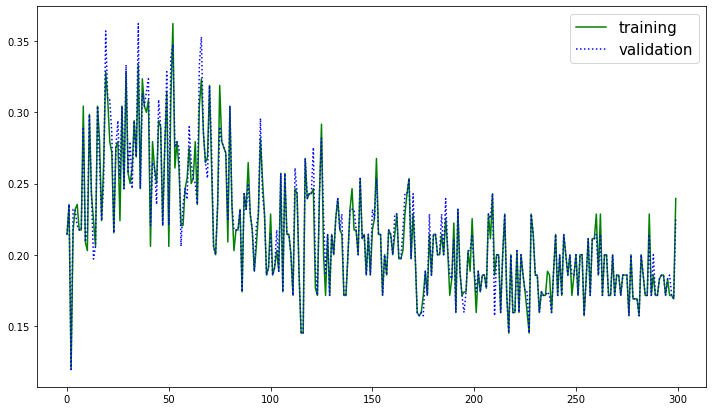

In [16]:
plt.figure(figsize=(12,7))
plt.plot(train_prop,'-g',label='training')
plt.plot(val_prop,':b',label='validation')
plt.legend(fontsize=15);

In [25]:
train_data0, val_data = train_test_split(OVS1618, test_size=0.18, random_state=42)

In [26]:
sampled_train = ctgan.sample(val_data.shape[0], condition_column=None,condition_value=None)

In [41]:
# For discrete data
def discrete_probs(column, unique_list):
    # find probability in the order of unique_list
    column = pd.Series(column)
    counts = column.value_counts()
    # freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    # probs = []
    # for k, v in freqs.items():
    #     probs.append(v/len(column))

    probs = []
    total_length = len(column)
    for i in unique_list:
        val = 0
        if i in counts.index:
            val = counts[i]
        probs.append(val/total_length)

    return np.array(probs)

# KL-divergence formula
def kl_divergence(p, q):
    # TODO: how to handle q == 0?
    # set a small number for numerical stability.
    p[p < 1e-8] = 1e-8
    q[q < 1e-8] = 1e-8
    a = np.log(p)
    b = np.log(q)
    return np.sum(p * (a - b))
    # return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [42]:
def ecdf(x):
    x = np.sort(x)
    u, c = np.unique(x, return_counts=True) #u: sorted x; c: count
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n ## Pe(x) in paper; When x=xi, U(x-xi)=0.5
    def interpolate_(x_): #Pc(x)
        yinterp = np.interp(x_, u, y, left=0.0, right=1.0)
        return yinterp
    return interpolate_


def cumulative_continuous_kl(x,y,fraction=0.5):
    dx = np.diff(np.sort(np.unique(x))) #Delta_x = xi-x_{i-1}
    dy = np.diff(np.sort(np.unique(y)))
    ex = np.min(dx) #min_i{xi-x_{i-1}}
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction # e should be smaller than ex and ey; so here multiply 0.5
    n = len(x)
    P = ecdf(x)
    Q = ecdf(y)
    p = P(x) - P(x-e)
    q = Q(x) - Q(x-e)
    p[p < 1e-8] = 1e-8
    q[q < 1e-8] = 1e-8
    KL = (1./n)*np.sum(np.log(p/q))
    return KL

In [97]:
def KLD(fake, real, discrete_columns):
    KLD = []
    for column in fake.columns:
        print(column)
        column_fake = fake[column].values
        column_real = real[column].values
        if column in discrete_columns:
            # find list of all unique values
            unique_list = []
            arrs = [np.unique(column_fake), np.unique(column_real)]
            for arr in arrs:
                for val in arr:
                    if val not in unique_list:
                        unique_list.append(val)
            # find probabilities of values according to order in unique_list
            fake_prob = discrete_probs(column_fake, unique_list)
            real_prob = discrete_probs(column_real, unique_list)
            KLD.append(kl_divergence(fake_prob, real_prob))
        else:
            # check whether indicator columns exist
            if column+'_cat' in fake.columns:
               column_fake = column_fake[fake[column+'_cat']==0]
               column_fake = column_fake[column_fake>0]
               column_real = column_real[real[column+'_cat']==0]
               column_real = column_real[column_real>0]
               if len(column_fake)>1 and len(column_real)>1:
                KLD.append(cumulative_continuous_kl(column_fake, column_real))
            else:
                KLD.append(cumulative_continuous_kl(column_fake, column_real))
            #maxval = max(max(column_real), max(column_fake))
            #minval = min(min(column_real), min(column_fake))
            #bins = np.linspace(start=minval, stop=maxval, num=20) ##Is number of bins too small?
            #bins = np.histogram_bin_edges(np.arange(minval, maxval), bins='auto')
            #fake_prob = continuous_probs(column_fake, bins)
            #real_prob = continuous_probs(column_real, bins)

            #mean_prob = (fake_prob+real_prob)/2
           

    # return np.mean(KLD), np.mean(JSD)
    return np.array(KLD)

In [69]:
fake = sampled_train
real = val_data

In [81]:
column = fake.columns[8]

In [82]:
column

'c4d_5.r'

In [91]:
column_fake = fake[column].values
column_real = real[column].values

In [92]:
column_real

array([-1., -1., -1., ..., -1., -1., -1.])

In [93]:
len(column_real)

11823

In [84]:
column_fake

array([-1.09217   , -1.02510331, -1.00194648, ..., -0.95149506,
       -0.97457114, -1.06387172])

In [85]:
fake[column+'_cat']

0        1
1        1
2        1
3        1
4        1
        ..
11818    1
11819    1
11820    1
11821    1
11822    1
Name: c4d_5.r_cat, Length: 11823, dtype: int64

In [86]:
cumulative_continuous_kl(column_fake, column_real)

0.3001974016694747

In [94]:
if column+'_cat' in fake.columns:
               column_fake = column_fake[fake[column+'_cat']==0]
               column_fake = column_fake[column_fake>0]
               column_real = column_real[real[column+'_cat']==0]
               column_real = column_real[column_real>0]

In [95]:
column_fake

array([57.98293357])

In [96]:
len(column_real)

277

In [88]:
len(column_fake)!=0 and len(column_real)!=0

True

In [78]:
cumulative_continuous_kl(column_fake, column_real)

ValueError: zero-size array to reduction operation minimum which has no identity

In [98]:
KLD(val_data, sampled_train, cat_cols)

c4d_1.r
c4d_1.r_cat
c4d_2.r
c4d_2.r_cat
c4d_3.r
c4d_3.r_cat
c4d_4.r
c4d_4.r_cat
c4d_5.r
c4d_5.r_cat
Expenditure on Service Apartment (c4d_6.r)
Expenditure on Service Apartment (c4d_6.r)_cat
c4d_7.r
c4d_7.r_cat
c4d_8.r
c4d_8.r_cat
Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)
Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat
Expenditure on Casual Dining (c6c_2.r)
Expenditure on Casual Dining (c6c_2.r)_cat
Expenditure on Fine-dining, Celebrity Chef Restaurants (c6c_3.r)
Expenditure on Fine-dining, Celebrity Chef Restaurants (c6c_3.r)_cat
c6c_4.r
c6c_4.r_cat
c7b_1.r
c7b_1.r_cat
Expenditure on Sightseeing (c10c_1.r)
Expenditure on Sightseeing (c10c_1.r)_cat
Expenditure on Attractions (c10c_2.r)
Expenditure on Attractions (c10c_2.r)_cat
Expenditure on Entertainment or Nightspots (c10c_3.r)
Expenditure on Entertainment or Nightspots (c10c_3.r)_cat
c10c_4.r
c10c_4.r_cat
c11_1.r
c11_1.r_cat
c11_2.r
c11_2.r_cat
c11_3.r
c11_3.r_cat
Expenditure on Education

array([5.52049138e-01, 2.05562218e-03, 3.81022940e+00, 2.08980522e-03,
       5.42937265e-03, 2.18247382e-04, 1.04734035e-02, 1.07437919e-05,
       4.30937570e-03, 8.60313539e-04, 5.27885320e-01, 3.86804418e-04,
       2.00647677e+00, 1.41569360e-03, 7.41759218e+00, 5.63610577e-03,
       3.57828481e-05, 5.89450507e-01, 9.70675590e-04, 2.85767035e+00,
       1.68631587e-03, 1.55937178e+00, 4.60227074e-03, 1.82921307e+00,
       1.93117568e-03, 7.49308332e-05, 7.66527394e-05, 3.05189848e-04,
       4.74730736e+00, 2.02134999e-03, 1.21886891e-03, 5.23266943e+00,
       6.57661864e-04, 3.57065057e+00, 2.20296577e-03, 4.44407127e+00,
       7.59216270e-06, 6.69010166e-06, 3.47405211e+00, 1.23324692e-03,
       1.65299611e+00, 4.53041516e-03, 2.65442421e+00, 1.30047922e-03,
       2.32828365e+00, 9.33217361e-04, 2.45768309e+00, 1.83535570e-03,
       2.29189244e+00, 5.60181564e-04, 6.53500878e-01, 1.30812692e-03,
       2.23862977e+00, 2.90538094e-03, 2.76530059e+00, 2.36430302e-03,
      

In [13]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618, discrete_columns=cat_cols, epochs=num_epochs, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
training data shape:  (53859, 101)
validation data shape:  (11823, 101)
0.005
num_components 14
num_components 1
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 15
num_components 14
num_components 5
num_components 1
num_components 14
num_components 11
num_components 13
num_components 6
num_components 1
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 11
num_components 4
num_components 6
num_components 7
num_components 9
num_components 12
num_components 10
num_components 6
num_components 2
num_components 2
num_components 5
num_components 6
num_components 2
num_components 2
num_components 6
num_components 7
transformed data shape:  (53859, 370)
data dimension: 370
Epoch 1, Loss G: -3.8804, Loss D: 0.7846
Epoch 2, Loss G: -3.1688, Loss D: 0.2134
Epoch 3, Loss G: -5.5861, Loss D

Epoch 172, Loss G: -0.5641, Loss D: -1.2607
Epoch 173, Loss G: -2.9735, Loss D: -0.8188
Epoch 174, Loss G: -2.0010, Loss D: -1.8851
Epoch 175, Loss G: -1.3486, Loss D: -0.8034
Epoch 176, Loss G: -0.6473, Loss D: -2.9316
Epoch 177, Loss G: -3.1080, Loss D: -1.6581
Epoch 178, Loss G: -0.2657, Loss D: 0.4969
Epoch 179, Loss G: -2.1557, Loss D: -1.7531
Epoch 180, Loss G: -2.7900, Loss D: -0.6117
Epoch 181, Loss G: -1.6689, Loss D: -0.3667
Epoch 182, Loss G: -2.3498, Loss D: 0.1437
Epoch 183, Loss G: -1.0423, Loss D: 1.4321
Epoch 184, Loss G: -1.1271, Loss D: -0.4496
Epoch 185, Loss G: -2.6939, Loss D: 0.9475
Epoch 186, Loss G: -3.2299, Loss D: -1.1106
Epoch 187, Loss G: -2.4013, Loss D: 2.6942
Epoch 188, Loss G: -2.6193, Loss D: -0.9117
Epoch 189, Loss G: -3.4582, Loss D: 0.0899
Epoch 190, Loss G: -0.7023, Loss D: -1.9702
Epoch 191, Loss G: -1.9452, Loss D: -0.1485
Epoch 192, Loss G: -1.7880, Loss D: 0.6946
Epoch 193, Loss G: -1.7504, Loss D: -0.1743
Epoch 194, Loss G: -1.2138, Loss D: -3.

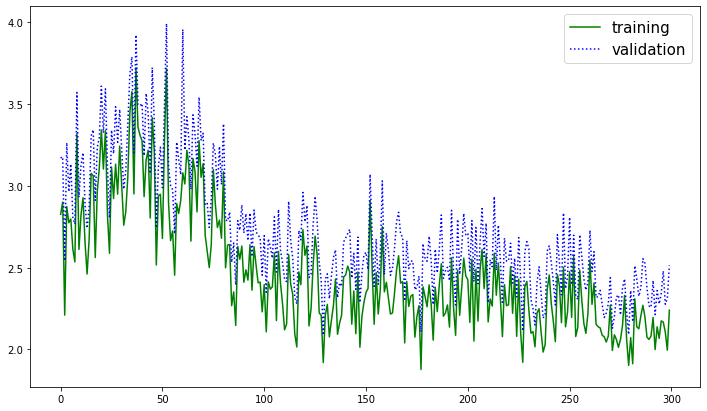

In [22]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.prop_similarity_train,'-g',label='training')
plt.plot(ctgan.prop_similarity_validation,':b',label='validation')
plt.legend(fontsize=15);
plt.savefig('KLD.pdf')

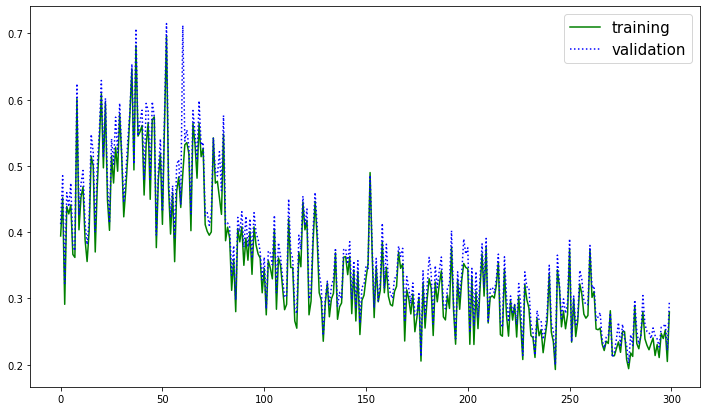

In [23]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.train_JSD,'-g',label='training')
plt.plot(ctgan.validation_JSD,':b',label='validation')
plt.legend(fontsize=15);
plt.savefig('JSD.pdf')

# TVAE

In [13]:
tvae = TVAESynthesizer()
print('Training TVAE is starting')
start_time = time.time()
tvae.fit(OVS1618, discrete_columns=cat_cols, epochs=num_epochs, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training TVAE is starting
Learning rate:  0.001
Number of epochs  300
Batch Size:  500
training data shape:  (53859, 101)
validation data shape:  (11823, 101)
num_components 14
num_components 1
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 15
num_components 14
num_components 5
num_components 1
num_components 14
num_components 11
num_components 13
num_components 6
num_components 1
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 11
num_components 4
num_components 6
num_components 7
num_components 9
num_components 12
num_components 10
num_components 6
num_components 2
num_components 2
num_components 5
num_components 6
num_components 2
num_components 2
num_components 6
num_components 7
data_dim 370
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weig

ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(-0.0025, grad_fn=<AddBackward0>) tensor(0.9713, grad_fn=<AddBackward0>)
Epoch 7, Loss: -51.9270
ema_mu, ema_std tensor(0.0014, grad_fn=<AddBackward0>) tensor(0.9626, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(0.0014, grad_fn=<AddBackward0>) tensor(0.9626, grad_fn=<AddBackward0>)
ema_mu, ema_std tensor(0.001

In [17]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618, discrete_columns=cat_cols, epochs=num_epochs, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
training data shape:  (53859, 101)
validation data shape:  (11823, 101)
0.005
num_components 15
num_components 2
num_components 1
num_components 1
num_components 2
num_components 1
num_components 1
num_components 1
num_components 14
num_components 15
num_components 6
num_components 1
num_components 14
num_components 11
num_components 13
num_components 7
num_components 1
num_components 1
num_components 1
num_components 3
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 1
num_components 11
num_components 4
num_components 4
num_components 6
num_components 9
num_components 12
num_components 11
num_components 5
num_components 2
num_components 2
num_components 6
num_components 6
num_components 2
num_components 2
num_components 6
num_components 8
transformed data shape:  (53859, 374)
data dimension: 374
Epoch 1, Loss G: 2.8503, Loss D: -2.3706
Epoch 2, Loss G: 2.7233, Loss D: -0.7594
Epoch 3, Loss G: 5.1648, Loss D:

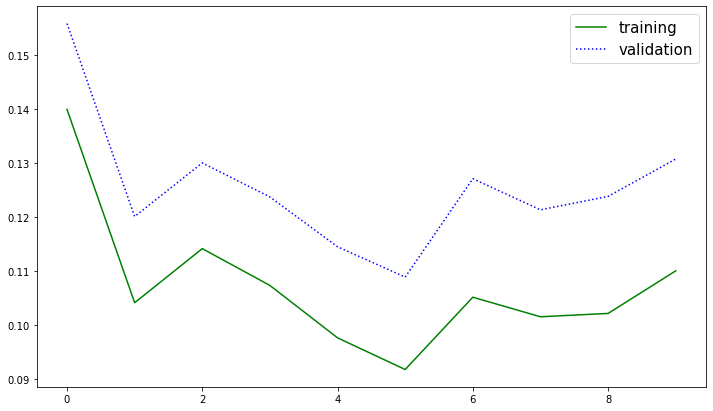

In [14]:
plt.figure(figsize=(12,7))
plt.plot(tvae.train_JSD,'-g',label='training')
plt.plot(tvae.validation_JSD,':b',label='validation')
plt.legend(fontsize=15);

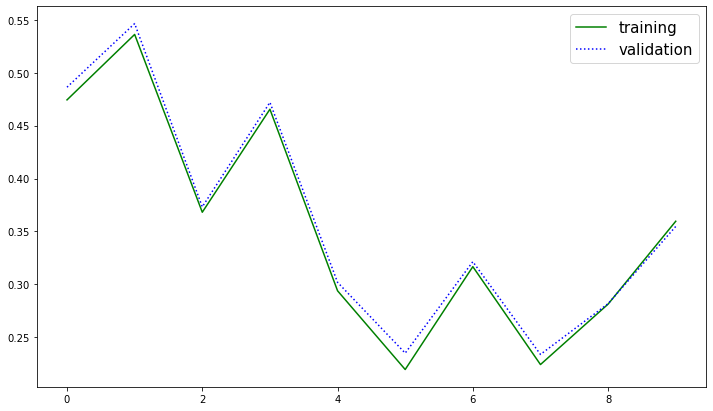

In [19]:
plt.figure(figsize=(12,7))
plt.plot(ctgan.train_JSD,'-g',label='training')
plt.plot(ctgan.validation_JSD,':b',label='validation')
plt.legend(fontsize=15);

In [33]:
0.474/101

0.004693069306930693

## Some codes to be used to debug

In [20]:
train_data, val_data = train_test_split(OVS1618, test_size=0.18, random_state=42)

In [21]:
sampled_train = ctgan.sample(val_data.shape[0], condition_column=None,condition_value=None)

In [22]:
fake = sampled_train

In [23]:
real = val_data

In [24]:
fake.shape

(11823, 101)

In [25]:
real.shape

(11823, 101)

In [29]:
# For discrete data
def discrete_probs(column, unique_list):
    # find probability in the order of unique_list
    column = pd.Series(column)
    counts = column.value_counts()
    # freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    # probs = []
    # for k, v in freqs.items():
    #     probs.append(v/len(column))

    probs = []
    total_length = len(column)
    for i in unique_list:
        val = 0
        if i in counts.index:
            val = counts[i]
        probs.append(val/total_length)

    return np.array(probs)


def continuous_probs(column,bins):
    column = pd.Series(np.digitize(column, bins))
    counts = column.value_counts()
    freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    for i in range(1, len(bins)+1):
        if i not in freqs.keys():
            freqs[i] = 0
    sorted_freqs = {}
    for k in sorted(freqs.keys()):
        sorted_freqs[k] = freqs[k]
    probs = []
    for k,v in sorted_freqs.items():
        probs.append(v/len(column))
    return np.array(probs)


# KL-divergence formula
def kl_divergence(p, q):
    # TODO: how to handle q == 0?
    # set a small number for numerical stability.
    p[p < 1e-8] = 1e-8
    q[q < 1e-8] = 1e-8
    a = np.log(p)
    b = np.log(q)
    return np.sum(p * (a - b))
    # return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [64]:
def KLD_JSD(fake, real, discrete_columns):
    KLD = []
    JSD = []
    for column in fake.columns:
        column_fake = fake[column].values
        column_real = real[column].values
        if column in discrete_columns:
            # find list of all unique values
            unique_list = []
            arrs = [np.unique(column_fake), np.unique(column_real)]
            for arr in arrs:
                for val in arr:
                    if val not in unique_list:
                        unique_list.append(val)
            # find probabilities of values according to order in unique_list
            fake_prob = discrete_probs(column_fake, unique_list)
            real_prob = discrete_probs(column_real, unique_list)
        else:
            maxval = max(max(column_real), max(column_fake))
            minval = min(min(column_real), min(column_fake))
            bins = np.linspace(start=minval, stop=maxval, num=100)
            # bins = np.linspace(start=minval, stop=maxval, num=20) ##Is number of bins too small?
           # bins = np.histogram_bin_edges(np.arange(minval, maxval), bins='auto')
            #print("number of bins:", len(bins))
            fake_prob = continuous_probs(column_fake, bins)
            real_prob = continuous_probs(column_real, bins)
        mean_prob = (fake_prob+real_prob)/2

        JSD.append((kl_divergence(fake_prob, mean_prob)+kl_divergence(real_prob, mean_prob))/2)
        print((kl_divergence(fake_prob, mean_prob)+kl_divergence(real_prob, mean_prob))/2)
        KLD.append(kl_divergence(fake_prob, real_prob))

    # return np.mean(KLD), np.mean(JSD)
    return sum(KLD), sum(JSD)


In [65]:
KLD_JSD(fake, real, cat_cols)

0.05710029889929646
0.005209080393075261
0.014449749063947208
0.0063150686542395446
0.0004980330792704106
0.002940660271624723
0.0017020150719342312
0.0072773749167378415
0.01000904343796573
0.0012138077224044894
0.0019370146757416804
0.00244557256597718
0.00011710134264021574
0.0015421255947247652
0.0008205805617524816
0.0019553776824590757
0.16435365633560897
0.0009290382992090084
0.22535327671876865
3.6970076120342553e-06
0.18135132517142022
0.000222075452050996
0.0008795096404571406
0.000911951241991878
0.19785147645792217
0.0002952436244943431
0.20471245591468468
0.013966104644199312
0.2081342941773246
0.0016364405584305356
0.043627336229432157
0.008992195027025234
0.0009088734243311873
0.0010360449894073202
0.00038072234798407434
0.0008811256609954686
5.858537636936681e-05
0.0017874325778288957
0.011531094901184216
0.0004368569867472154
0.0013201655472449704
0.0026383380892010047
0.005630535694374812
0.0004227637581221259
0.0007915396731982061
0.001009294740252526
0.0005566013331

(41.81801939245195, 2.336260257965086)

In [45]:
np.log(2)

0.6931471805599453

In [34]:
column=fake.columns[0] 

In [35]:
column

'c4d_1.r'

In [36]:
column_fake = fake[column].values
column_real = real[column].values

In [37]:
maxval = max(max(column_real), max(column_fake))
minval = min(min(column_real), min(column_fake))

In [67]:
bins = np.linspace(start=minval, stop=maxval, num=20)

In [54]:
bins = np.histogram_bin_edges(np.arange(minval, maxval), bins='auto')

In [60]:
len(continuous_probs(column_fake,bins))

100

In [2]:
a = pd.cut(column_real,bins).value_counts() / len(column_real)

NameError: name 'pd' is not defined

In [3]:
a[0]

NameError: name 'a' is not defined

In [69]:
continuous_probs(column_real,bins)

array([0.41935211, 0.14784742, 0.13981223, 0.11097014, 0.0633511 ,
       0.04660408, 0.02647382, 0.01843864, 0.00668189, 0.00625899,
       0.00668189, 0.00346782, 0.0021991 , 0.00126871, 0.00059207,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [62]:
(continuous_probs(column_fake,bins)+continuous_probs(column_real,bins))/2

array([3.47331473e-01, 1.27294257e-02, 1.74236657e-02, 2.66852745e-02,
       1.68315994e-02, 3.68349827e-02, 2.46976233e-02, 2.79539880e-02,
       2.96033156e-02, 2.79962784e-02, 2.05531591e-02, 4.03450901e-02,
       2.47822042e-02, 3.43821365e-02, 2.57125941e-02, 1.62395331e-02,
       4.02182187e-02, 1.11646790e-02, 1.76774084e-02, 1.50131100e-02,
       1.06571936e-02, 1.63241140e-02, 4.22904508e-03, 4.35591643e-03,
       1.97919310e-02, 9.09244693e-03, 1.06994841e-02, 2.63046604e-02,
       4.65194959e-03, 8.28892836e-03, 8.33121881e-03, 4.22904508e-03,
       9.00786602e-03, 1.94536074e-03, 1.98765119e-03, 2.53742705e-03,
       1.77619893e-03, 3.34094561e-03, 1.98765119e-03, 3.84843102e-03,
       4.99027320e-03, 7.18937664e-04, 2.96033156e-04, 1.98765119e-03,
       3.38323607e-04, 8.03518566e-04, 8.45809016e-04, 1.14184217e-03,
       1.64932758e-03, 7.61228115e-04, 7.18937664e-04, 8.45809016e-04,
       1.31100398e-03, 3.08720291e-03, 3.80614057e-04, 5.49775861e-04,
      

In [63]:
kl_divergence(continuous_probs(column_fake,bins),continuous_probs(column_real,bins))

0.3413313954731458

In [22]:
bins = np.histogram_bin_edges(np.arange(minval, maxval), bins='fd')

In [26]:
len(bins)

17

In [24]:
bins1 = np.linspace(start=minval, stop=maxval, num=20)

In [25]:
bins1

array([ -13.75300992,  170.03732614,  353.8276622 ,  537.61799826,
        721.40833431,  905.19867037, 1088.98900643, 1272.77934249,
       1456.56967855, 1640.36001461, 1824.15035066, 2007.94068672,
       2191.73102278, 2375.52135884, 2559.3116949 , 2743.10203096,
       2926.89236701, 3110.68270307, 3294.47303913, 3478.26337519])

In [37]:
bins

array([ -17.98503945,  167.99408071,  353.97320088,  539.95232104,
        725.9314412 ,  911.91056136, 1097.88968152, 1283.86880168,
       1469.84792184, 1655.827042  , 1841.80616216, 2027.78528232,
       2213.76440248, 2399.74352265, 2585.72264281, 2771.70176297,
       2957.68088313, 3143.66000329, 3329.63912345, 3515.61824361])

In [27]:
bins2 = np.histogram_bin_edges(np.arange(minval, maxval), bins='auto')

In [29]:
len(bins2)

17

In [103]:
np.linspace(start=minval, stop=maxval, num=176)

array([-1.79850394e+01,  2.20697931e+00,  2.23989981e+01,  4.25910168e+01,
        6.27830356e+01,  8.29750544e+01,  1.03167073e+02,  1.23359092e+02,
        1.43551111e+02,  1.63743129e+02,  1.83935148e+02,  2.04127167e+02,
        2.24319186e+02,  2.44511204e+02,  2.64703223e+02,  2.84895242e+02,
        3.05087261e+02,  3.25279279e+02,  3.45471298e+02,  3.65663317e+02,
        3.85855336e+02,  4.06047355e+02,  4.26239373e+02,  4.46431392e+02,
        4.66623411e+02,  4.86815430e+02,  5.07007448e+02,  5.27199467e+02,
        5.47391486e+02,  5.67583505e+02,  5.87775523e+02,  6.07967542e+02,
        6.28159561e+02,  6.48351580e+02,  6.68543598e+02,  6.88735617e+02,
        7.08927636e+02,  7.29119655e+02,  7.49311673e+02,  7.69503692e+02,
        7.89695711e+02,  8.09887730e+02,  8.30079748e+02,  8.50271767e+02,
        8.70463786e+02,  8.90655805e+02,  9.10847824e+02,  9.31039842e+02,
        9.51231861e+02,  9.71423880e+02,  9.91615899e+02,  1.01180792e+03,
        1.03199994e+03,  

In [38]:
bins1 = np.arange(minval, maxval, 20)

In [50]:
-1.79850394e+01+20

2.0149605999999984

In [39]:
bins1

array([-1.79850394e+01,  2.01496055e+00,  2.20149606e+01,  4.20149606e+01,
        6.20149606e+01,  8.20149606e+01,  1.02014961e+02,  1.22014961e+02,
        1.42014961e+02,  1.62014961e+02,  1.82014961e+02,  2.02014961e+02,
        2.22014961e+02,  2.42014961e+02,  2.62014961e+02,  2.82014961e+02,
        3.02014961e+02,  3.22014961e+02,  3.42014961e+02,  3.62014961e+02,
        3.82014961e+02,  4.02014961e+02,  4.22014961e+02,  4.42014961e+02,
        4.62014961e+02,  4.82014961e+02,  5.02014961e+02,  5.22014961e+02,
        5.42014961e+02,  5.62014961e+02,  5.82014961e+02,  6.02014961e+02,
        6.22014961e+02,  6.42014961e+02,  6.62014961e+02,  6.82014961e+02,
        7.02014961e+02,  7.22014961e+02,  7.42014961e+02,  7.62014961e+02,
        7.82014961e+02,  8.02014961e+02,  8.22014961e+02,  8.42014961e+02,
        8.62014961e+02,  8.82014961e+02,  9.02014961e+02,  9.22014961e+02,
        9.42014961e+02,  9.62014961e+02,  9.82014961e+02,  1.00201496e+03,
        1.02201496e+03,  

In [41]:
len(bins1)

177

In [43]:
column1 = pd.Series(np.digitize(column_fake, bins))

In [65]:
column1

0        3
1        1
2        3
3        3
4        7
        ..
11818    1
11819    2
11820    1
11821    1
11822    7
Length: 11823, dtype: int64

In [66]:
column2

0        25
1         5
2        26
3        27
4        61
         ..
11818     2
11819    10
11820     1
11821     1
11822    58
Length: 11823, dtype: int64

In [48]:
len(column1)

11823

(array([5.793e+03, 4.222e+03, 1.291e+03, 3.390e+02, 1.070e+02, 2.200e+01,
        2.000e+01, 1.900e+01, 8.000e+00, 2.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

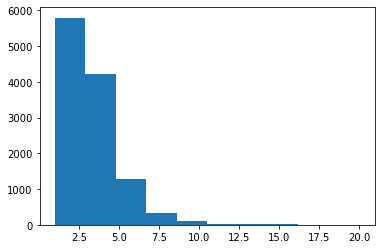

In [44]:
plt.hist(column1)

(array([5682., 4200., 1291.,  443.,  112.,   42.,   16.,   18.,   13.,
           6.]),
 array([ -17.98503945,  335.37528886,  688.73561717, 1042.09594547,
        1395.45627378, 1748.81660208, 2102.17693039, 2455.53725869,
        2808.897587  , 3162.2579153 , 3515.61824361]),
 <a list of 10 Patch objects>)

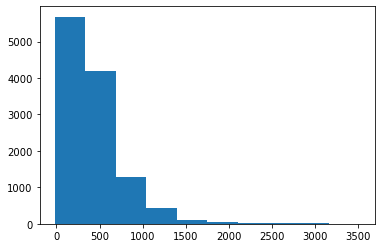

In [45]:
plt.hist(column_fake)

In [51]:
len(column_fake)

11823

In [46]:
column2 = pd.Series(np.digitize(column_fake, bins1))

In [49]:
len(column2)

11823

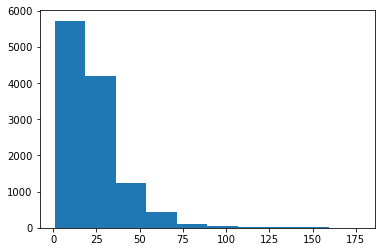

In [47]:
plt.hist(column2);

In [53]:
column_cat = fake.columns[1]

In [54]:
column_cat

'c4d_1.r_cat'

In [59]:
column_fake = fake[column_cat].values
column_real = real[column_cat].values

In [60]:
column_fake

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [61]:
unique_list = []
arrs = [np.unique(column_fake), np.unique(column_real)]

In [62]:
arrs

[array([0, 1], dtype=int64), array([0, 1], dtype=int64)]

In [63]:
for arr in arrs:
                for val in arr:
                    if val not in unique_list:
                        unique_list.append(val)

In [64]:
unique_list

[0, 1]

In [67]:
def continuous_probs(column,bins):
    column = pd.Series(np.digitize(column, bins))
    counts = column.value_counts()
    freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    for i in range(1, len(bins)+1):
        if i not in freqs.keys():
            freqs[i] = 0
    sorted_freqs = {}
    for k in sorted(freqs.keys()):
        sorted_freqs[k] = freqs[k]
    probs = []
    for k,v in sorted_freqs.items():
        probs.append(v/len(column))
    return np.array(probs)

In [ ]:
def discrete_probs(column, unique_list):
    # find probability in the order of unique_list
    column = pd.Series(column)
    counts = column.value_counts()
    # freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    # probs = []
    # for k, v in freqs.items():
    #     probs.append(v/len(column))

    probs = []
    total_length = len(column)
    for i in unique_list:
        val = 0
        if i in counts.index:
            val = counts[i]
        probs.append(val/total_length)

    return np.array(probs)

In [68]:
def discret_probs(column):
    column = pd.Series(column)
    counts = column.value_counts()
    freqs ={counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    probs = []
    for k,v in freqs.items():
        probs.append(v/len(column))
    return np.array(probs)

def identify_probs(column,bins):
    column = pd.Series(np.digitize(column, bins))
    counts = column.value_counts()
    freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}
    for i in range(1, len(bins)+1):
        if i not in freqs.keys():
            freqs[i] = 0
    sorted_freqs = {}
    for k in sorted(freqs.keys()):
        sorted_freqs[k] = freqs[k]
    probs = []
    for k,v in sorted_freqs.items():
        probs.append(v/len(column))
    return np.array(probs)

# KL-divergence formula
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [71]:
continuous_probs(column_fake,bins)

array([3.59891736e-01, 1.30085427e-01, 1.90983676e-01, 1.66116891e-01,
       6.13211537e-02, 4.78727903e-02, 1.68315994e-02, 1.18413262e-02,
       4.14446418e-03, 4.90569229e-03, 1.01497082e-03, 8.45809016e-04,
       8.45809016e-04, 8.45809016e-04, 7.61228115e-04, 8.45809016e-04,
       2.53742705e-04, 4.22904508e-04, 8.45809016e-05, 8.45809016e-05])

In [78]:
continuous_probs(column_real,bins)

array([0.41470016, 0.1443796 , 0.13118498, 0.11037808, 0.07375455,
       0.0473653 , 0.02816544, 0.01201049, 0.01539372, 0.00693563,
       0.00642815, 0.00372156, 0.00262201, 0.00143788, 0.00109955,
       0.0004229 , 0.        , 0.        , 0.        , 0.        ])

In [74]:
sum(continuous_probs(column_fake,bins))

1.0

In [75]:
len(continuous_probs(column_fake,bins))

20

In [79]:
continuous_probs(column_real,bins1)

array([3.35870760e-01, 1.01497082e-03, 5.07485410e-04, 1.94536074e-03,
       5.49775861e-03, 1.50554005e-02, 2.70658885e-02, 8.88099467e-03,
       1.66624376e-02, 1.14184217e-02, 2.32597479e-02, 1.17567453e-02,
       9.47306098e-03, 1.80157320e-02, 9.81138459e-03, 3.27328089e-02,
       1.03188700e-02, 6.93563393e-03, 1.77619893e-02, 6.85105303e-03,
       3.17178381e-02, 7.02021484e-03, 5.24401590e-03, 1.79311511e-02,
       7.69686205e-03, 3.67926922e-02, 7.95060475e-03, 7.44311934e-03,
       1.27717161e-02, 5.66692041e-03, 3.69618540e-02, 4.31362598e-03,
       3.72155967e-03, 8.20434746e-03, 6.68189123e-03, 2.30905861e-02,
       4.99027320e-03, 5.07485410e-03, 1.37866870e-02, 5.15943500e-03,
       2.41901379e-02, 3.72155967e-03, 2.28368434e-03, 4.56736869e-03,
       1.09955172e-03, 1.44633342e-02, 2.28368434e-03, 1.77619893e-03,
       4.39820688e-03, 2.79116975e-03, 2.80808593e-02, 2.19910344e-03,
       2.45284615e-03, 1.69161803e-03, 2.02994164e-03, 3.12949336e-03,
      

In [72]:
continuous_probs(column_fake,bins1)

array([1.47424512e-01, 8.46654825e-02, 1.01497082e-02, 1.24333925e-02,
       1.59857904e-02, 1.81003129e-02, 1.95381883e-02, 2.31751670e-02,
       2.11452254e-02, 2.13989681e-02, 1.84386366e-02, 1.51399814e-02,
       1.38712679e-02, 1.49708196e-02, 1.26025543e-02, 1.37021061e-02,
       1.15030026e-02, 9.72680369e-03, 9.89596549e-03, 7.78144295e-03,
       1.53091432e-02, 1.76774084e-02, 2.45284615e-02, 2.39363952e-02,
       2.44438806e-02, 2.51205278e-02, 2.58817559e-02, 2.48667851e-02,
       3.10411909e-02, 3.36631988e-02, 3.21407426e-02, 2.36826525e-02,
       1.53937241e-02, 9.13473738e-03, 5.66692041e-03, 5.15943500e-03,
       6.85105303e-03, 6.34356762e-03, 7.10479574e-03, 6.85105303e-03,
       5.92066311e-03, 6.51272943e-03, 6.76647213e-03, 6.76647213e-03,
       7.02021484e-03, 6.34356762e-03, 5.24401590e-03, 6.76647213e-03,
       5.92066311e-03, 5.15943500e-03, 5.92066311e-03, 5.15943500e-03,
       5.07485410e-03, 4.65194959e-03, 3.72155967e-03, 3.29865516e-03,
      

In [76]:
sum(continuous_probs(column_fake,bins1))

1.0000000000000009

In [77]:
len(continuous_probs(column_fake,bins1))

177

In [24]:
 bins = np.arange(min(min(column_real),min(column_fake)),max(max(column_real),max(column_fake)), 20) # value increased by 20

In [25]:
bins

array([-1.85029513e+01,  1.49704873e+00,  2.14970487e+01,  4.14970487e+01,
        6.14970487e+01,  8.14970487e+01,  1.01497049e+02,  1.21497049e+02,
        1.41497049e+02,  1.61497049e+02,  1.81497049e+02,  2.01497049e+02,
        2.21497049e+02,  2.41497049e+02,  2.61497049e+02,  2.81497049e+02,
        3.01497049e+02,  3.21497049e+02,  3.41497049e+02,  3.61497049e+02,
        3.81497049e+02,  4.01497049e+02,  4.21497049e+02,  4.41497049e+02,
        4.61497049e+02,  4.81497049e+02,  5.01497049e+02,  5.21497049e+02,
        5.41497049e+02,  5.61497049e+02,  5.81497049e+02,  6.01497049e+02,
        6.21497049e+02,  6.41497049e+02,  6.61497049e+02,  6.81497049e+02,
        7.01497049e+02,  7.21497049e+02,  7.41497049e+02,  7.61497049e+02,
        7.81497049e+02,  8.01497049e+02,  8.21497049e+02,  8.41497049e+02,
        8.61497049e+02,  8.81497049e+02,  9.01497049e+02,  9.21497049e+02,
        9.41497049e+02,  9.61497049e+02,  9.81497049e+02,  1.00149705e+03,
        1.02149705e+03,  

In [90]:
# KL-divergence formula
def kl_divergence(p, q):
    # TODO: how to handle q == 0?
    # set a small number for numerical stability.
    p[p < 1e-8] = 1e-8
    q[q < 1e-8] = 1e-8
    a = np.log(p)
    b = np.log(q)
    return np.sum(p * (a - b))
    # return np.sum(np.where(p != 0, p * np.log(p / q), 0))


In [96]:
kl_divergence(continuous_probs(column_fake,bins),continuous_probs(column_real,bins))

0.05265790949318854

In [94]:
import scipy.stats

In [98]:
p = continuous_probs(column_fake,bins)

In [99]:
q = continuous_probs(column_real,bins)

In [100]:
p[p < 1e-8] = 1e-8
q[q < 1e-8] = 1e-8

In [101]:
scipy.stats.entropy(p,q)

0.052657949493187486

In [26]:
fake_prob = identify_probs(column_fake,bins).reshape([-1, 1])
real_prob = identify_probs(column_real,bins).reshape([-1, 1])

(array([7.387e+03, 3.152e+03, 1.268e+03, 9.440e+02, 2.270e+02, 8.600e+01,
        2.900e+01, 2.100e+01, 1.600e+01, 7.000e+00]),
 array([ -18.50295127,  324.7360927 ,  667.97513666, 1011.21418062,
        1354.45322459, 1697.69226855, 2040.93131251, 2384.17035648,
        2727.40940044, 3070.6484444 , 3413.88748837]),
 <a list of 10 Patch objects>)

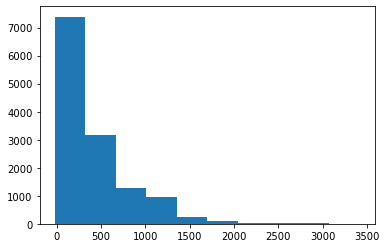

In [30]:
plt.hist(column_fake)

In [31]:
column = pd.Series(np.digitize(column_fake, bins))

In [46]:
len(column)/20

656.85

(array([7.507e+03, 3.068e+03, 1.317e+03, 8.650e+02, 2.230e+02, 8.400e+01,
        2.800e+01, 2.200e+01, 1.600e+01, 7.000e+00]),
 array([  1. ,  18.1,  35.2,  52.3,  69.4,  86.5, 103.6, 120.7, 137.8,
        154.9, 172. ]),
 <a list of 10 Patch objects>)

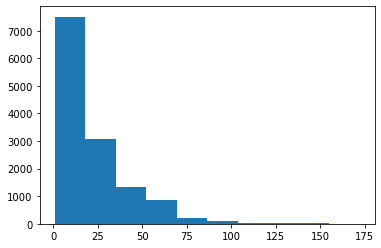

In [32]:
plt.hist(column)

In [38]:
len(column_fake)

13137

In [33]:
counts = column.value_counts()
freqs = {counts.index[i]: counts.values[i] for i in range(len(counts.index))}

In [34]:
freqs

{1: 3345,
 2: 1844,
 31: 393,
 32: 364,
 30: 344,
 29: 271,
 33: 241,
 8: 188,
 11: 185,
 14: 184,
 12: 183,
 13: 173,
 9: 170,
 16: 168,
 22: 157,
 10: 156,
 18: 152,
 52: 150,
 7: 149,
 51: 147,
 24: 145,
 25: 143,
 21: 140,
 15: 139,
 49: 139,
 6: 139,
 50: 139,
 23: 138,
 17: 135,
 34: 134,
 53: 129,
 54: 127,
 48: 124,
 28: 120,
 19: 115,
 26: 115,
 20: 110,
 47: 96,
 27: 92,
 55: 90,
 5: 89,
 4: 63,
 56: 62,
 36: 53,
 40: 52,
 43: 52,
 38: 51,
 46: 50,
 37: 49,
 39: 49,
 65: 47,
 35: 46,
 44: 45,
 3: 45,
 57: 44,
 42: 42,
 45: 41,
 59: 40,
 60: 40,
 66: 40,
 41: 38,
 62: 35,
 61: 34,
 68: 33,
 64: 32,
 58: 32,
 69: 30,
 63: 28,
 70: 28,
 67: 22,
 72: 20,
 73: 17,
 77: 16,
 71: 16,
 74: 14,
 75: 13,
 81: 13,
 78: 13,
 80: 13,
 89: 11,
 79: 11,
 76: 10,
 88: 10,
 84: 10,
 87: 10,
 83: 9,
 94: 9,
 85: 9,
 91: 8,
 90: 8,
 93: 8,
 82: 7,
 126: 5,
 98: 5,
 86: 4,
 96: 4,
 95: 4,
 115: 3,
 121: 3,
 109: 3,
 149: 3,
 161: 3,
 92: 3,
 118: 2,
 139: 2,
 105: 2,
 152: 2,
 145: 2,
 119: 2,
 

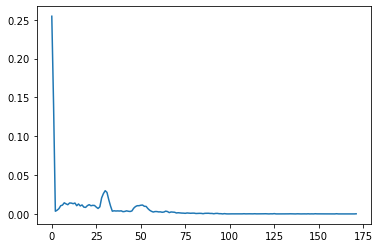

In [36]:
plt.plot(fake_prob)

In [47]:
len(fake_prob)

172

In [43]:
def KLD_JSD(fake,real,discrete_columns):
    KLD = []
    JSD = []
    for column in fake.columns:
        column_fake = fake[column].values
        column_real = real[column].values
        bins = np.arange(min(min(column_real),min(column_fake)),max(max(column_real),max(column_fake)), 20)
        if column in discrete_columns:
            fake_prob = discret_probs(column_fake)
            real_prob = discret_probs(column_real)
        else:
            fake_prob = identify_probs(column_fake,bins)
            real_prob = identify_probs(column_real,bins)
        mean_prob = (fake_prob+real_prob)/2
        JSD.append((kl_divergence(fake_prob,mean_prob)+kl_divergence(real_prob,mean_prob))/2)
        KLD.append(kl_divergence(fake_prob,real_prob))


    return sum(KLD),sum(JSD)

In [44]:
KLD_JSD(fake,real,cat_cols)

<ipython-input-17-4eba337a5e5f>:27: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-17-4eba337a5e5f>:27: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-17-4eba337a5e5f>:27: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-17-4eba337a5e5f>:27: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


(inf, 1.2149371911616118)

In [41]:
identify_probs(column_fake,bins).shape

(172,)

In [42]:
identify_probs(column_real,bins).shape

(172,)